In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!ls

drive  model_49.pth  sample_data


In [1]:
''' 
This script does conditional image generation on MNIST, using a diffusion model

This code is modified from,
https://github.com/cloneofsimo/minDiffusion

Diffusion model is based on DDPM,
https://arxiv.org/abs/2006.11239

The conditioning idea is taken from 'Classifier-Free Diffusion Guidance',
https://arxiv.org/abs/2207.12598

This technique also features in ImageGen 'Photorealistic Text-to-Image Diffusion Modelswith Deep Language Understanding',
https://arxiv.org/abs/2205.11487

'''

from typing import Dict, Tuple
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np



The code below defines a class called ResidualConvBlock that represents a residual convolutional block in a UNet architecture. It initializes with input and output channel numbers and a flag indicating whether to perform a residual connection. The block consists of two sequential convolutional layers with batch normalization and GELU activation. During the forward pass, if the residual connection is enabled, the input tensor is added to the output tensor of the second convolution, considering the channel compatibility. If the residual connection is disabled, only the output of the second convolution is returned. This block enables the network to capture and retain important features while learning additional features, serving as a fundamental component in a UNet architecture.

By using batch normalization and GELU activation, the ResidualConvBlock aims to improve the training process, stabilize the network's internal covariate shift, and enhance the expressive power of the model. These techniques can contribute to better convergence, faster training, and improved performance in deep learning models.

In [2]:
# Residual ConvBlock
# Build the Unet
class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()
        '''
        standard ResNet style convolutional block
        '''
        self.same_channels = in_channels==out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            # this adds on correct residual in case channels have increased
            if self.same_channels:
                out = x + x2
            else:
                out = x1 + x2 
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

The code defines a class called UnetDown that represents a downsampling module in a UNet architecture. It takes an input tensor, applies a residual convolutional block followed by max pooling to downscale and process the feature maps, and returns the result. This module is commonly used in the encoder section of the UNet to reduce the spatial dimensions of the input and capture higher-level features.

In [3]:
class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        '''
        process and downscale the image feature maps
        '''
        layers = [ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*[ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)])

    def forward(self, x):
        return self.model(x)


This code defines a class called UnetUp that represents an upsampling module in a UNet architecture. It takes an input tensor x and a skip connection tensor skip, concatenates them along the channel dimension, and applies a series of operations to process and upscale the feature maps. These operations include a transpose convolution to increase the spatial dimensions, followed by multiple residual convolutional blocks. The resulting feature maps are returned as the output. This module is typically used in the decoder section of the UNet to reconstruct high-resolution feature maps using skip connections from the encoder.

In [4]:
class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        '''
        process and upscale the image feature maps
        '''
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x

The following code defines a class called EmbedFC that represents a generic one-layer fully connected neural network (FC NN) for embedding input data. It takes an input tensor x and applies a linear transformation followed by a GELU activation function and another linear transformation. The resulting tensor represents the embedded representation of the input. The input tensor is reshaped to have a size of (-1, input_dim) before passing it through the FC NN. This class is commonly used for embedding various types of data, such as text, images, or numerical features, into a lower-dimensional representation.

In [5]:
class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        generic one layer FC NN for embedding things  
        '''
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)

The given code defines a class called ContextUnet that represents a modified version of the UNet architecture, incorporating context information and time steps into the network.

The forward pass of this network takes as input a noisy image x, a context label c, a time step t, and a context mask context_mask. The image is initially processed through several downsampling blocks, and the resulting feature maps are embedded into a lower-dimensional representation. The context label and time step are one-hot encoded and multiplied with corresponding embedding layers. The context information is masked using the context mask to control which samples have context information. The embedded representations are then upsampled and combined with the downsampling feature maps using addition and multiplication operations. The final output is obtained by passing the concatenated feature maps through a series of convolutional layers. This modified UNet architecture allows the network to incorporate context and temporal information into the image denoising process.

In [6]:
class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat = 256, n_classes=10):
        super(ContextUnet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_classes = n_classes

        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)

        self.to_vec = nn.Sequential(nn.AvgPool2d(8), nn.GELU())

        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_classes, 2*n_feat)
        self.contextembed2 = EmbedFC(n_classes, 1*n_feat)

        self.up0 = nn.Sequential(
            # nn.ConvTranspose2d(6 * n_feat, 2 * n_feat, 7, 7), # when concat temb and cemb end up w 6*n_feat
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 8, 8), # otherwise just have 2*n_feat
            nn.GroupNorm(8, 2 * n_feat),
            nn.ReLU(),
        )

        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, c, t, context_mask):
        # x is (noisy) image, c is context label, t is timestep, 
        # context_mask says which samples to block the context on

        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2)

        # convert context to one hot embedding
        c = nn.functional.one_hot(c, num_classes=self.n_classes).type(torch.float)
        
        # mask out context if context_mask == 1
        context_mask = context_mask[:, None]
        context_mask = context_mask.repeat(1,self.n_classes)
        context_mask = (-1*(1-context_mask)) # need to flip 0 <-> 1
        c = c * context_mask
        
        # embed context, time step
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)

        # could concatenate the context embedding here instead of adaGN
        # hiddenvec = torch.cat((hiddenvec, temb1, cemb1), 1)

        up1 = self.up0(hiddenvec)
        # up2 = self.up1(up1, down2) # if want to avoid add and multiply embeddings
        up2 = self.up1(cemb1*up1+ temb1, down2)  # add and multiply embeddings
        up3 = self.up2(cemb2*up2+ temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out

This code defines a function `ddpm_schedules` that computes and returns pre-computed schedules for training and sampling in a Deep Density Model (DDPM). 

The function takes three parameters: `beta1`, `beta2`, and `T`. It first checks that `beta1` and `beta2` are within the range (0, 1). 

The function then calculates various schedules based on these input parameters. It computes `beta_t` as a linear interpolation between `beta1` and `beta2` over `T` steps. It computes the square root of `beta_t` and assigns it to `sqrt_beta_t`. 

Furthermore, it calculates `alpha_t` as `1 - beta_t` and computes the logarithm of `alpha_t` to obtain `log_alpha_t`. `alphabar_t` is computed as the cumulative sum of `log_alpha_t`, exponentiated. 

Other variables computed include `sqrtab` as the square root of `alphabar_t`, `oneover_sqrta` as the reciprocal of the square root of `alpha_t`, `sqrtmab` as the square root of `1 - alphabar_t`, and `mab_over_sqrtmab_inv` as `(1 - alpha_t)` divided by the square root of `1 - alphabar_t`. 

The function returns a dictionary containing all these computed schedules, each associated with a specific key. These schedules are used in the DDPM training process for sampling and other operations.

In [7]:
def ddpm_schedules(beta1, beta2, T):
    """
    Returns pre-computed schedules for DDPM sampling, training process.
    """
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"

    beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab

    return {
        "alpha_t": alpha_t,  # \alpha_t
        "oneover_sqrta": oneover_sqrta,  # 1/\sqrt{\alpha_t}
        "sqrt_beta_t": sqrt_beta_t,  # \sqrt{\beta_t}
        "alphabar_t": alphabar_t,  # \bar{\alpha_t}
        "sqrtab": sqrtab,  # \sqrt{\bar{\alpha_t}}
        "sqrtmab": sqrtmab,  # \sqrt{1-\bar{\alpha_t}}
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,  # (1-\alpha_t)/\sqrt{1-\bar{\alpha_t}}
    }

The following code defines a PyTorch module called DDPM (Deep Density Model) used for training and sampling in a deep generative model.

The module takes an nn_model as input, which represents a neural network model, along with betas, n_T, device, and drop_prob parameters.

During initialization, the ddpm_schedules function is called to compute various schedules, and these schedules are registered as buffers using register_buffer in the module. Additionally, an MSE loss function is initialized.

The forward method is used for training. It takes noisy input x and context labels c as input. It randomly generates a timestep _ts from a uniform distribution and generates Gaussian noise. It then applies transformations to the input based on the computed schedules and passes it through the neural network model. The method returns the mean squared error (MSE) loss between the generated noise and the predicted noise.

The sample method is used for generating samples from the model. It takes parameters for the number of samples, size of the samples, the device to use, and a guidance weight guide_w. It iterates over the timesteps in reverse order and generates samples by transforming the initial noise using the computed schedules and the neural network model. It applies a mixing operation between the two halves of the batch based on the guidance weight. The method returns the generated samples and also stores the generated samples at different timesteps for plotting purposes.

The x_noise method takes a noisy input x, a device, and a starting timestep n_start. It applies transformations to the input based on the schedules and returns the transformed input.

The custom_sample method is similar to the sample method but allows for custom sampling. It takes a noisy input x_noisy, batch size, sample size, context labels c, a starting index start_idx, the number of repeats, and the device. It iterates over the timesteps and generates samples by transforming the input using the computed schedules and the neural network model. It stores the generated samples at different timesteps and returns the final generated samples.






In [8]:
class DDPM(nn.Module):
    def __init__(self, nn_model, betas, n_T, device, drop_prob=0.1):
        super(DDPM, self).__init__()
        self.nn_model = nn_model.to(device)

        # register_buffer allows accessing dictionary produced by ddpm_schedules
        # e.g. can access self.sqrtab later
        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

        self.n_T = n_T
        self.device = device
        self.drop_prob = drop_prob
        self.loss_mse = nn.MSELoss()

    def forward(self, x, c):
        """
        this method is used in training, so samples t and noise randomly
        """

        _ts = torch.randint(1, self.n_T, (x.shape[0],)).to(self.device)  # t ~ Uniform(0, n_T)
        noise = torch.randn_like(x)  # eps ~ N(0, 1)

        x_t = (
            self.sqrtab[_ts, None, None, None] * x
            + self.sqrtmab[_ts, None, None, None] * noise
        )  # This is the x_t, which is sqrt(alphabar) x_0 + sqrt(1-alphabar) * eps
        # We should predict the "error term" from this x_t. Loss is what we return.

        # dropout context with some probability
        context_mask = torch.bernoulli(torch.zeros_like(c)+self.drop_prob).to(self.device)
        
        # return MSE between added noise, and our predicted noise
        return self.loss_mse(noise, self.nn_model(x_t, c, _ts / self.n_T, context_mask))

    def sample(self, n_sample, size, device, guide_w = 0.0):
        # we follow the guidance sampling scheme described in 'Classifier-Free Diffusion Guidance'
        # to make the fwd passes efficient, we concat two versions of the dataset,
        # one with context_mask=0 and the other context_mask=1
        # we then mix the outputs with the guidance scale, w
        # where w>0 means more guidance

        x_i = torch.randn(n_sample, *size).to(device)  # x_T ~ N(0, 1), sample initial noise
        c_i = torch.arange(0,10).to(device) # context for us just cycles throught the mnist labels
        c_i = c_i.repeat(int(n_sample/c_i.shape[0]))

        # don't drop context at test time
        context_mask = torch.zeros_like(c_i).to(device)

        # double the batch
        c_i = c_i.repeat(2)
        context_mask = context_mask.repeat(2)
        context_mask[n_sample:] = 1. # makes second half of batch context free

        x_i_store = [] # keep track of generated steps in case want to plot something 
        print()
        for i in range(self.n_T, 0, -1):
            print(f'sampling timestep {i}',end='\r')
            t_is = torch.tensor([i / self.n_T]).to(device)
            t_is = t_is.repeat(n_sample,1,1,1)

            # double batch
            x_i = x_i.repeat(2,1,1,1)
            t_is = t_is.repeat(2,1,1,1)

            z = torch.randn(n_sample, *size).to(device) if i > 1 else 0

            # split predictions and compute weighting
            eps = self.nn_model(x_i, c_i, t_is, context_mask)
            eps1 = eps[:n_sample]
            eps2 = eps[n_sample:]
            eps = (1+guide_w)*eps1 - guide_w*eps2
            x_i = x_i[:n_sample]
            x_i = (
                self.oneover_sqrta[i] * (x_i - eps * self.mab_over_sqrtmab[i])
                + self.sqrt_beta_t[i] * z
            )
            if i%20==0 or i==self.n_T or i<8:
                x_i_store.append(x_i.detach().cpu().numpy())
        
        x_i_store = np.array(x_i_store)
        return x_i, x_i_store
    
    def x_noise(self, x, device, n_start):
        _ts = torch.ones((x.shape[0],), device=device).long()*n_start
        _ts = _ts.type(torch.int64)
        noise = torch.randn_like(x)  # eps ~ N(0, 1)

        x_t = (
            self.sqrtab[_ts, None, None, None] * x
            + self.sqrtmab[_ts, None, None, None] * noise
        )  # This is the x_t, which is sqrt(alphabar) x_0 + sqrt(1-alphabar) * eps
        # We should predict the "error term" from this x_t. Loss is what we return.
        
        return x_t
    
    def custom_sample(self, x_noisy, batch_size, size, c, start_idx, repeats, device):
        context_mask = torch.zeros_like(c).to(device)
        x_store = []
        print()
        # plt.imshow(x_noisy[0].reshape(28,28))
        # plt.show()
        for i in range(repeats):
            for j in range(start_idx, 0, -1):
                # if j%(start_idx%5)==0 or j==start_idx:
                #     print("i: "+ str(i) + "   j:" + str(j))
                t_is = torch.tensor([j / self.n_T]).to(device)
                t_is = t_is.repeat(batch_size,1,1,1)
                # print("A")
                z = torch.randn(batch_size, *size).to(device) if j > 1 else 0
                # print("B")
                # split predictions and compute weighting
                eps = self.nn_model(x_noisy, c, t_is, context_mask)
                # print("C")
                x_noisy = (
                    self.oneover_sqrta[j] * (x_noisy - eps * self.mab_over_sqrtmab[j])
                    + self.sqrt_beta_t[j] * z
                )
                # print("D")
                # if j%5 == 0:
                    # plt.imshow(x_noisy[0].detach().numpy().reshape(28,28))
                    # print("E")
                    # plt.show()
                # print("F")
              
                # !nvidia-smi
                if j%max(1, start_idx//5)==0 or j==start_idx or j==1:
                    # print(j)
                    x_store.append(x_noisy.detach().cpu().numpy())

        x_store = np.array(x_store)
        return x_noisy, x_store

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [9]:
import torchvision
batch_size = 256

# Transform the images to tensors and normalize them
transform = transforms.Compose([
    transforms.ToTensor()

])

# Download and load the CIFAR-10 training set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# Download and load the CIFAR-10 test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


The code below trains a deep generative model called DDPM on the CIFAR-10 dataset. It initializes the model, optimizer, and various training parameters, then enters a training loop where it iterates over the data, computes the loss, and updates the model parameters. After each epoch, it generates samples from the trained model and saves them as images

In [27]:
def train_cifar10():
    loss_all = []
    # hardcoding these here
    # n_epoch = 20
    n_epoch = 50
    # batch_size = 1
    n_T = 1000
    device = "cuda:0"
    n_classes = 10
    n_feat = 128 # 128 ok, 256 better (but slower)
    lrate = 1e-4
    save_model = True
    save_dir = './data/diffusion_outputs10/'
    model_dir = './data/diffusion_outputs10/model_49.pth'
    ws_test = [0.0, 0.5, 2.0] # strength of generative guidance

    ddpm = DDPM(
        nn_model=ContextUnet(
            in_channels=3,
            n_feat=n_feat,
            n_classes=n_classes
        ),
        betas=(1e-4, 0.02),
        n_T=n_T, device=device,
        drop_prob=0.1
    )
    ddpm.load_state_dict(torch.load(model_dir, map_location=torch.device('cpu')))

    ddpm.to(device)

    optim = torch.optim.Adam(ddpm.parameters(), lr=lrate)

    for ep in range(n_epoch):
        print(f'epoch {ep}')
        ddpm.train()

        # linear lrate decay
        optim.param_groups[0]['lr'] = lrate*(1-ep/n_epoch)

        pbar = tqdm(trainloader)
        loss_ema = None
        for x, c in pbar:
            optim.zero_grad()
            x = x.to(device)
            c = c.to(device)
            loss = ddpm(x, c)
            loss.backward()
            if loss_ema is None:
                loss_ema = loss.item()
            else:
                loss_ema = 0.95 * loss_ema + 0.05 * loss.item()
            pbar.set_description(f"loss: {loss_ema:.4f}")
            optim.step()
           
        print('Loss ema:',loss_ema)
        print('loss',loss)
        loss_all.append(loss_ema)
        # print(loss_all)
        
        # for eval, save an image of currently generated samples (top rows)
        # followed by real images (bottom rows)
        ddpm.eval()
        with torch.no_grad():
            n_sample = 4*n_classes
            for w_i, w in enumerate(ws_test):
                x_gen, x_gen_store = ddpm.sample(n_sample, (3, 32, 32), device, guide_w=w)

                # append some real images at bottom, order by class also
                x_real = torch.Tensor(x_gen.shape).to(device)
                for k in range(n_classes):
                    for j in range(int(n_sample/n_classes)):
                        try: 
                            idx = torch.squeeze((c == k).nonzero())[j]
                        except:
                            idx = 0
                        x_real[k+(j*n_classes)] = x[idx]

                x_all = torch.cat([x_gen, x_real])
                grid = make_grid(x_all*-1 + 1, nrow=10)
                save_image(grid, save_dir + f"image_ep{ep}_w{w}.png")
#                 print('saved image at ' + save_dir + f"image_ep{ep}_w{w}.png")
        # optionally save model
        if save_model and ep == int(n_epoch-1):
            ep = ep + 50
            torch.save(ddpm.state_dict(), save_dir + f"model_1000nT_{ep}.pth")
            print('saved model at ' + save_dir + f"model_1000nT_{ep}.pth")
            return loss_all

In [10]:
import os

# Specify the directory path
directory_path = "./data/diffusion_outputs10"

# Check if the directory already exists
if not os.path.exists(directory_path):
    # Create the directory
    os.makedirs(directory_path)

In [28]:
loss_all = train_cifar10()

epoch 0


loss: 0.0207: 100%|██████████| 196/196 [00:56<00:00,  3.50it/s]


Loss ema: 0.020687544186254243
loss tensor(0.0270, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
epoch 1g timestep 1000


loss: 0.0211: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Loss ema: 0.021072453828166353
loss tensor(0.0251, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
epoch 2g timestep 1000


loss: 0.0199: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Loss ema: 0.01985798001746845
loss tensor(0.0198, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
epoch 3g timestep 1000


loss: 0.0193: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Loss ema: 0.01931208510664196
loss tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
epoch 4g timestep 1000


loss: 0.0199: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Loss ema: 0.019922791681906995
loss tensor(0.0193, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
epoch 5g timestep 1000


loss: 0.0195: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Loss ema: 0.019511422315372846
loss tensor(0.0234, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
epoch 6g timestep 1000


loss: 0.0193: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Loss ema: 0.019276320206795334
loss tensor(0.0237, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
epoch 7g timestep 1000


loss: 0.0201: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Loss ema: 0.02010859117169347
loss tensor(0.0223, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
epoch 8g timestep 1000


loss: 0.0199: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Loss ema: 0.0198682823363667
loss tensor(0.0258, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
epoch 9g timestep 1000


loss: 0.0202: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Loss ema: 0.020208212887093895
loss tensor(0.0390, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
epoch 10 timestep 1000


loss: 0.0192: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Loss ema: 0.019191761597147954
loss tensor(0.0302, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
epoch 11 timestep 1000


loss: 0.0201: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Loss ema: 0.020079539180914038
loss tensor(0.0246, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
epoch 12 timestep 1000


loss: 0.0192: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Loss ema: 0.019221559767720317
loss tensor(0.0227, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
epoch 13 timestep 1000


loss: 0.0193: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Loss ema: 0.019293097347992474
loss tensor(0.0240, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
epoch 14 timestep 1000


loss: 0.0200: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Loss ema: 0.020010135040733797
loss tensor(0.0219, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
epoch 15 timestep 1000


loss: 0.0195: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Loss ema: 0.019476004428638144
loss tensor(0.0233, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
epoch 16 timestep 1000


loss: 0.0198: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Loss ema: 0.019804920671193372
loss tensor(0.0265, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
epoch 17 timestep 1000


loss: 0.0188: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Loss ema: 0.01881974931734841
loss tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
epoch 18 timestep 1000


loss: 0.0188: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Loss ema: 0.018769711296377074
loss tensor(0.0166, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
epoch 19 timestep 1000


loss: 0.0194: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Loss ema: 0.01938087364578444
loss tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
epoch 20 timestep 1000


loss: 0.0189: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Loss ema: 0.018855763475980985
loss tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
epoch 21 timestep 1000


loss: 0.0183: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Loss ema: 0.018326394085077323
loss tensor(0.0165, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
epoch 22 timestep 1000


loss: 0.0184: 100%|██████████| 196/196 [00:56<00:00,  3.47it/s]


Loss ema: 0.018370286730691167
loss tensor(0.0224, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
epoch 23 timestep 1000


loss: 0.0201: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Loss ema: 0.02012447690043279
loss tensor(0.0238, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
epoch 24 timestep 1000


loss: 0.0182: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Loss ema: 0.01817928581204816
loss tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
epoch 25 timestep 1000


loss: 0.0185: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Loss ema: 0.01846939082089481
loss tensor(0.0229, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
epoch 26 timestep 1000


loss: 0.0201: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Loss ema: 0.02010679202433435
loss tensor(0.0233, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
epoch 27 timestep 1000


loss: 0.0183: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Loss ema: 0.01831282420243456
loss tensor(0.0175, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
epoch 28 timestep 1000


loss: 0.0184: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Loss ema: 0.018422552220257928
loss tensor(0.0172, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
epoch 29 timestep 1000


loss: 0.0192: 100%|██████████| 196/196 [00:56<00:00,  3.47it/s]


Loss ema: 0.019229058652086652
loss tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
epoch 30 timestep 1000


loss: 0.0187: 100%|██████████| 196/196 [00:56<00:00,  3.47it/s]


Loss ema: 0.018665348405796884
loss tensor(0.0218, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
epoch 31 timestep 1000


loss: 0.0189: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Loss ema: 0.01892876767250559
loss tensor(0.0258, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
epoch 32 timestep 1000


loss: 0.0190: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Loss ema: 0.019037112036773093
loss tensor(0.0197, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
epoch 33 timestep 1000


loss: 0.0188: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Loss ema: 0.018844663213188527
loss tensor(0.0241, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
epoch 34 timestep 1000


loss: 0.0189: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Loss ema: 0.01888496393580837
loss tensor(0.0170, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
epoch 35 timestep 1000


loss: 0.0191: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Loss ema: 0.019123444327405825
loss tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
epoch 36 timestep 1000


loss: 0.0185: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Loss ema: 0.018545298429145818
loss tensor(0.0238, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
epoch 37 timestep 1000


loss: 0.0191: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Loss ema: 0.01908177981536564
loss tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
epoch 38 timestep 1000


loss: 0.0191: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Loss ema: 0.019128823510471692
loss tensor(0.0280, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
epoch 39 timestep 1000


loss: 0.0187: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Loss ema: 0.018728450484518454
loss tensor(0.0275, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
epoch 40 timestep 1000


loss: 0.0193: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Loss ema: 0.019303899534045137
loss tensor(0.0180, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
epoch 41 timestep 1000


loss: 0.0183: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Loss ema: 0.018303953612674242
loss tensor(0.0221, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
epoch 42 timestep 1000


loss: 0.0184: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Loss ema: 0.018403090831609625
loss tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
epoch 43 timestep 1000


loss: 0.0179: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Loss ema: 0.01790852738283926
loss tensor(0.0148, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
epoch 44 timestep 1000


loss: 0.0190: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Loss ema: 0.01904153873750889
loss tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
epoch 45 timestep 1000


loss: 0.0195: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Loss ema: 0.019548010950397012
loss tensor(0.0262, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
epoch 46 timestep 1000


loss: 0.0189: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Loss ema: 0.01892871421717673
loss tensor(0.0323, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
epoch 47 timestep 1000


loss: 0.0188: 100%|██████████| 196/196 [00:56<00:00,  3.47it/s]


Loss ema: 0.0187958777875932
loss tensor(0.0264, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
epoch 48 timestep 1000


loss: 0.0188: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Loss ema: 0.01875946942044012
loss tensor(0.0205, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
epoch 49 timestep 1000


loss: 0.0188: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Loss ema: 0.018791730960203118
loss tensor(0.0179, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1000
sampling timestep 1000
saved model at ./data/diffusion_outputs10/model_1000nT_99.pth


In [39]:
print(loss_all)

[0.0757884863045116]


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
[0.020687544186254243, 0.021072453828166353, 0.01985798001746845, 0.01931208510664196, 0.019922791681906995, 0.019511422315372846, 0.019276320206795334, 0.02010859117169347, 0.0198682823363667, 0.020208212887093895, 0.019191761597147954, 0.020079539180914038, 0.019221559767720317, 0.019293097347992474, 0.020010135040733797, 0.019476004428638144, 0.019804920671193372, 0.01881974931734841, 0.018769711296377074, 0.01938087364578444, 0.018855763475980985, 0.018326394085077323, 0.018370286730691167, 0.02012447690043279, 0.01817928581204816, 0.01846939082089481, 0.02010679202433435, 0.01831282420243456, 0.018422552220257928, 0.019229058652086652, 0.018665348405796884, 0.01892876767250559, 0.019037112036773093, 0.018844663213188527, 0.01888496393580837, 0.019123444327405825, 0.018545298429145818, 0.01908

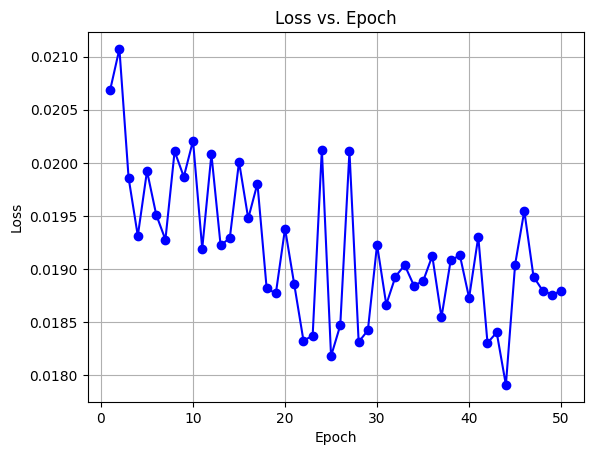

In [29]:
import matplotlib.pyplot as plt

# Example data
epochs = list(range(1,51))
print(epochs)
loss_values = loss_all
print(loss_all)


# Plotting the graph
plt.plot(epochs, loss_values, marker='o', linestyle='-', color='blue')

# Customize the plot
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.grid(True)

# Show the plot
plt.show()


In [15]:
# hardcoding these here
# n_epoch = 20
batch_size = 256
n_T = 1000 # 500
device = "cpu:0"
n_classes = 10
n_feat = 128 # 128 ok, 256 better (but slower)
# lrate = 1e-4
# save_model = False
# model_dir = './data/diffusion_outputs10/model_1000nT_99.pth'
model_dir = './model_99.pth'
save_dir = './data/diffusion_outputs10/'
# ws_test = [0.0, 0.5, 2.0] # strength of generative guidance

This loads a pretrained model into an instance of the DDPM (Diffusion Models) class. First, a DDPM object is created, specifying the architecture of the underlying neural network model (ContextUnet) with specific parameters such as the number of input channels, number of features, and number of classes. The betas, n_T, device, and drop_prob parameters are also set. Then, the state dictionary of the pretrained model is loaded from the specified model directory using torch.load(), and the loaded state dictionary is assigned to the DDPM model using load_state_dict(). Finally, the model is moved to the specified device for computation using to(device).

In [16]:
# optionally load a model

ddpm = DDPM(
    nn_model=ContextUnet(
        in_channels=3,
        n_feat=n_feat,
        n_classes=n_classes
    ),
    betas=(1e-4, 0.02),
    n_T=n_T, device=device,
    drop_prob=0.1
)

ddpm.load_state_dict(torch.load(model_dir, map_location=torch.device('cpu')))
ddpm.to(device)

DDPM(
  (nn_model): ContextUnet(
    (init_conv): ResidualConvBlock(
      (conv1): Sequential(
        (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none')
      )
      (conv2): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none')
      )
    )
    (down1): UnetDown(
      (model): Sequential(
        (0): ResidualConvBlock(
          (conv1): Sequential(
            (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): GELU(approximate='none')
          )
          (conv2): Sequential(
            (0): Conv2d(128, 128, kernel_size=(3, 

The code sets the DDPM model to evaluation mode using ddpm.eval(). Then, it iterates over the trainloader data loader, which presumably contains input data and labels. For each batch of data, it moves the data and labels to the specified device (presumably a GPU) using .to(device)

In [17]:
ddpm.eval()
for x_,c_ in trainloader:
    x_ = x_.to(device)
    c_ = c_.to(device)

# next(iter(data_loader))

The code defines a function called plot_graphs that takes various parameters for generating plots. It iterates over a specified number of samples and creates multiple subplots, including the original input image, noisy versions of the input, and generated samples. The repeats parameter controls the number of iterations for generating variations of samples, while start_index determines the initial generated sample to display. The function also calculates and prints the mean squared error (MSE) score between specific generated samples and the original input. Finally, the plots are shown using plt.show().

In [18]:
def plot_graphs(features, labels, noise_start, num_samples, start_index, repeats, device):
    for i in range(num_samples):
        x_i = features[i:i+1]
        c_i = labels[i:i+1]
        # print(x_i.shape)
        x_noisy = ddpm.x_noise(x=x_i, device=device, n_start=noise_start)
        # print(x_noisy.shape)
        x_gen, x_store = ddpm.custom_sample(x_noisy, x_i.shape[0], (3,32,32), c_i, start_index, repeats, device)
        fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1, 7, figsize=(15,15))
        print(x_store[0].shape)
        ax1.imshow(np.transpose(x_i[0].squeeze(0), (1,2,0)))
        if repeats==1:
            ax2.imshow(np.transpose(x_store[0].squeeze(0), (1, 2, 0)))
            ax3.imshow(np.transpose(x_store[1].squeeze(0), (1, 2, 0)))
            ax4.imshow(np.transpose(x_store[2].squeeze(0), (1, 2, 0)))
            ax5.imshow(np.transpose(x_store[3].squeeze(0), (1, 2, 0)))
            ax6.imshow(np.transpose(x_store[4].squeeze(0), (1, 2, 0)))
            ax7.imshow(np.transpose(x_store[5].squeeze(0), (1, 2, 0)))
            score = nn.MSELoss((np.transpose(x_store[5].squeeze(0), (1, 2, 0))).all(), (np.transpose(x_store[0].squeeze(0), (1, 2, 0))).all(), reduction='mean')
            print(score)
        if repeats==3:
            ax2.imshow(np.transpose(x_store[0].squeeze(0), (1, 2, 0)))
            ax3.imshow(np.transpose(x_store[3].squeeze(0), (1, 2, 0)))
            ax4.imshow(np.transpose(x_store[7].squeeze(0), (1, 2, 0)))
            ax5.imshow(np.transpose(x_store[10].squeeze(0), (1, 2, 0)))
            ax6.imshow(np.transpose(x_store[14].squeeze(0), (1, 2, 0)))
            ax7.imshow(np.transpose(x_store[17].squeeze(0), (1, 2, 0)))
            score = nn.MSELoss((np.transpose(x_store[17].squeeze(0), (1, 2, 0))).all(), (np.transpose(x_store[0].squeeze(0), (1, 2, 0))).all(), reduction='mean')
            print(score)
        if repeats==40 and start_index==2:
            ax2.imshow(np.transpose(x_store[0].squeeze(0), (1, 2, 0)))
            ax3.imshow(np.transpose(x_store[16].squeeze(0), (1, 2, 0)))
            ax4.imshow(np.transpose(x_store[32].squeeze(0), (1, 2, 0)))
            ax5.imshow(np.transpose(x_store[48].squeeze(0), (1, 2, 0)))
            ax6.imshow(np.transpose(x_store[64].squeeze(0), (1, 2, 0)))
            ax7.imshow(np.transpose(x_store[79].squeeze(0), (1, 2, 0)))
            score = nn.MSELoss((np.transpose(x_store[79].squeeze(0), (1, 2, 0))).all(), (np.transpose(x_store[0].squeeze(0), (1, 2, 0))).all(), reduction='mean')
            print(score)
        if repeats!=1 and repeats!=3 and repeats!=40:
            print("repeats should be 1, 3 or 40")
        plt.show()

In [19]:
n_start = 160
n_sample = 5
x = x_[:n_sample]
c = c_[:n_sample]

In [22]:
print(c)

tensor([4, 5, 6, 8, 2])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


/ext3/miniconda3/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


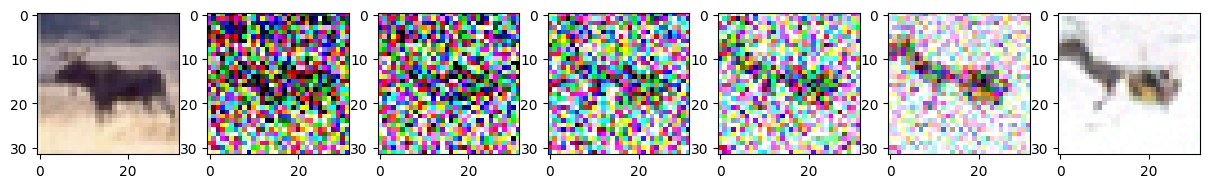

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


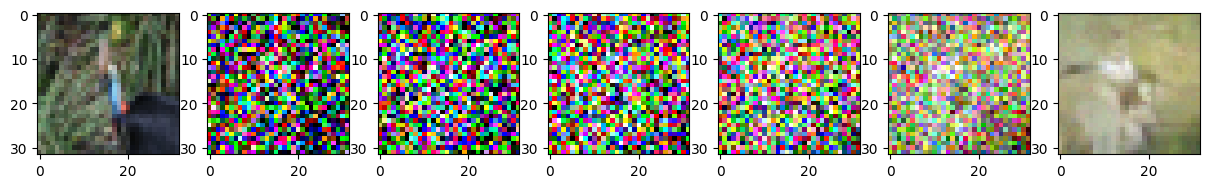

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


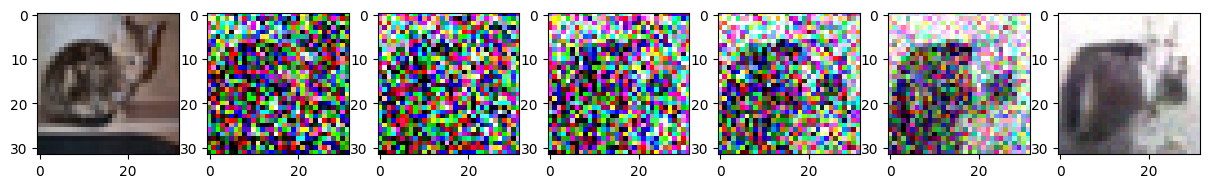

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


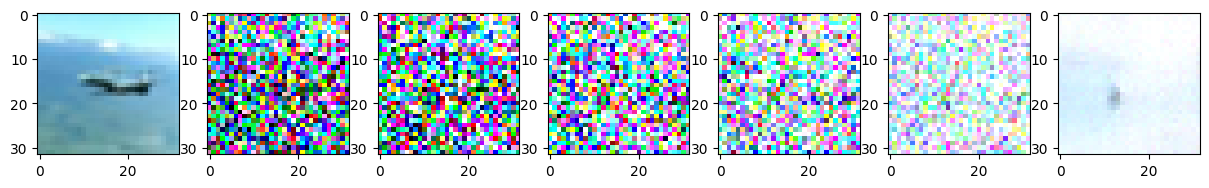

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


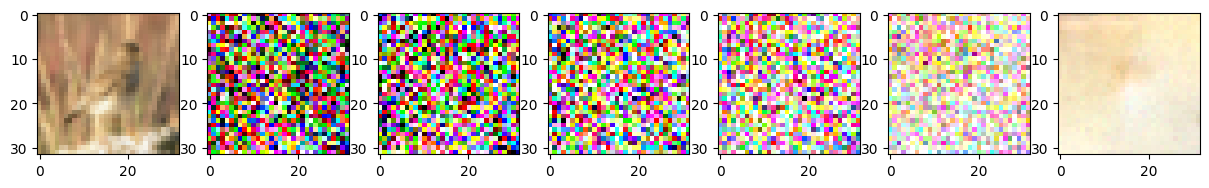

In [20]:
n_start = 200
n_sample = 5
x = x_[:n_sample]
c = c_[:n_sample]

start_idx = 400 # 80% of 200
repeats = 1


plot_graphs(x, c, n_start, n_sample, start_idx, repeats, device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


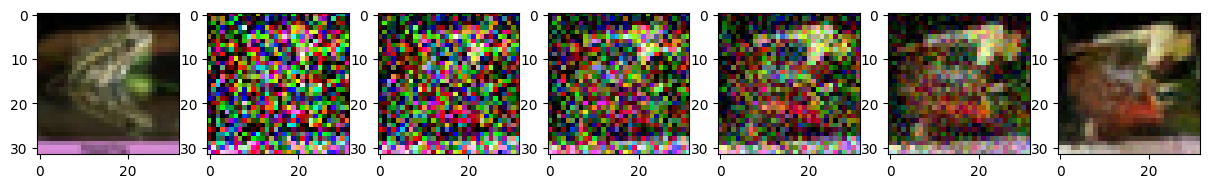

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


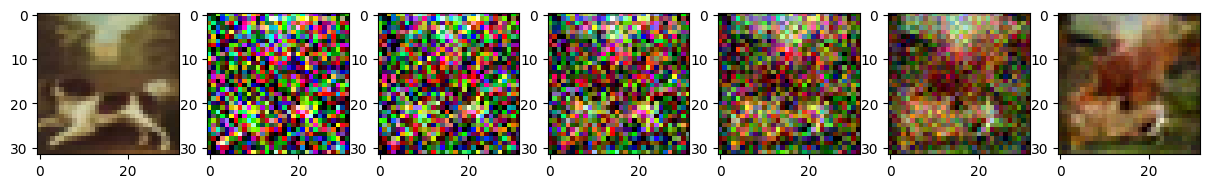

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


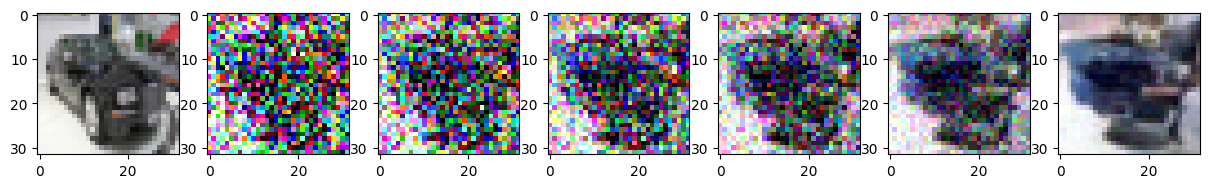

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


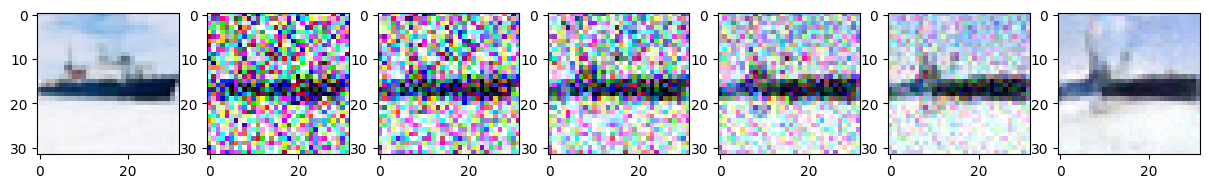

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


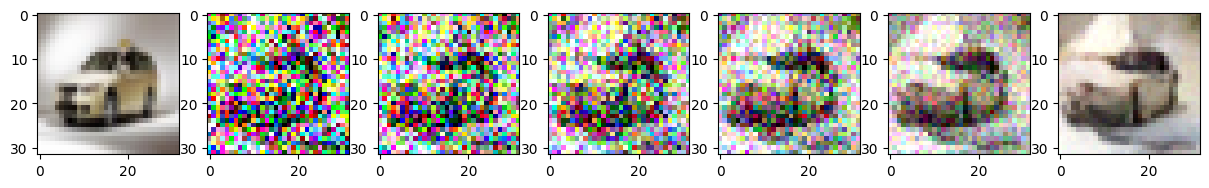

In [35]:

start_idx = 160 # 80% of 200
repeats = 1


plot_graphs(x, c, n_start, n_sample, start_idx, repeats, device)

In [36]:
custom_class = 3

c_custom = torch.Tensor([custom_class for i in range(n_sample)])
c_custom = c_custom.type(torch.int64)

In [ ]:
print(c_custom)

tensor([3, 3, 3, 3, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


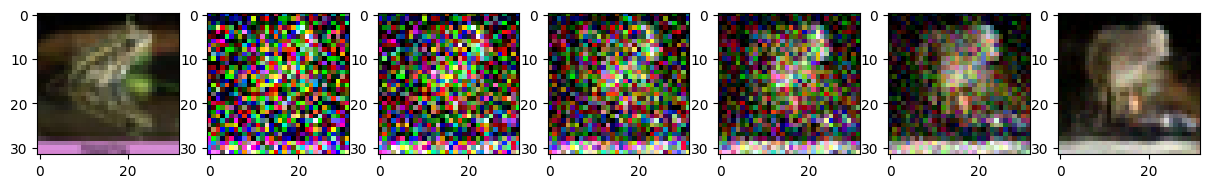

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


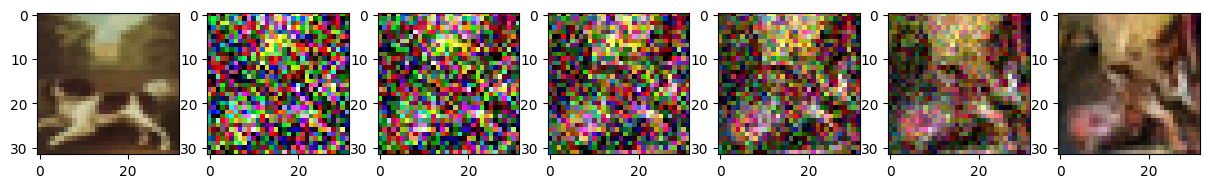

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


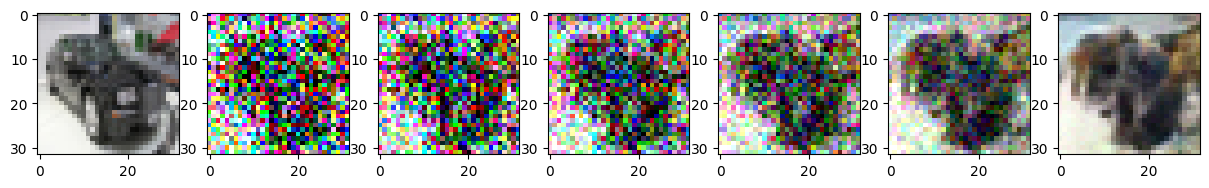

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


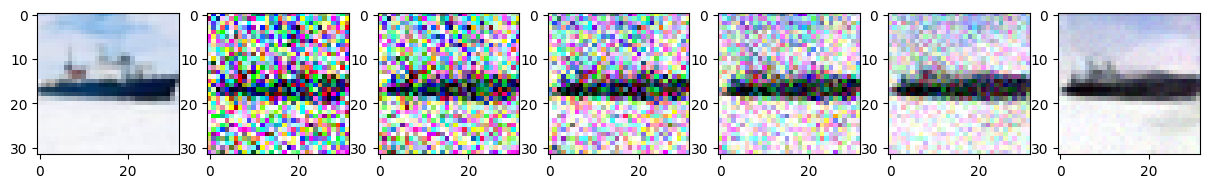

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


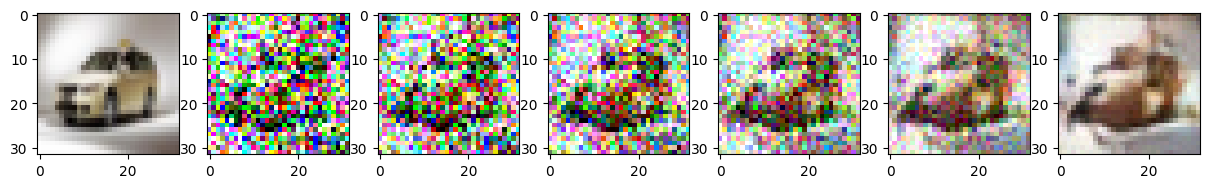

In [37]:
start_idx = 160 # 80% of 200
repeats = 1

plot_graphs(x, c_custom, n_start, n_sample, start_idx, repeats, device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


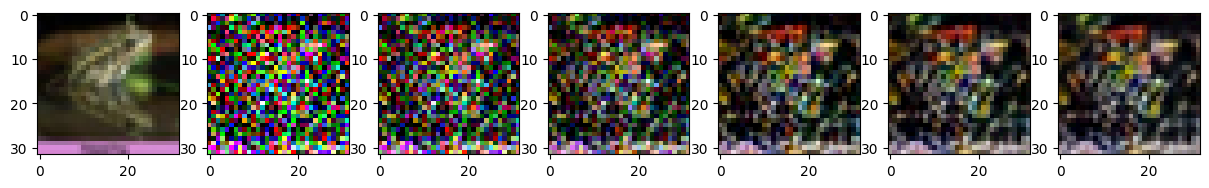

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


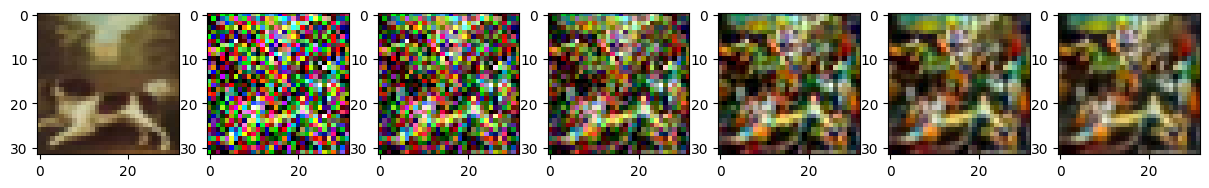

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


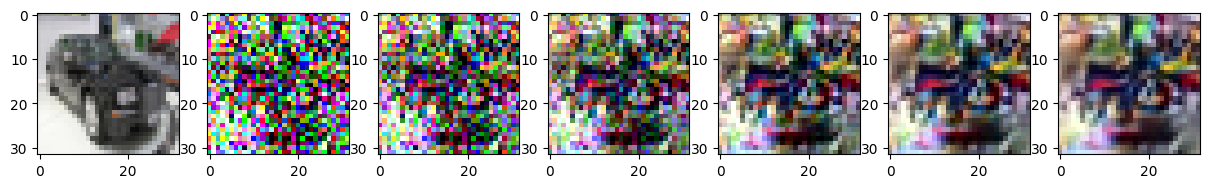

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


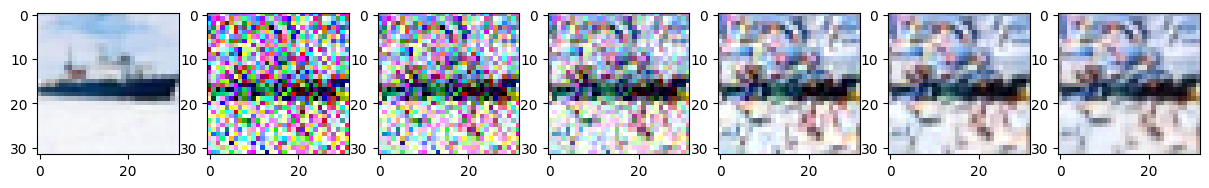

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


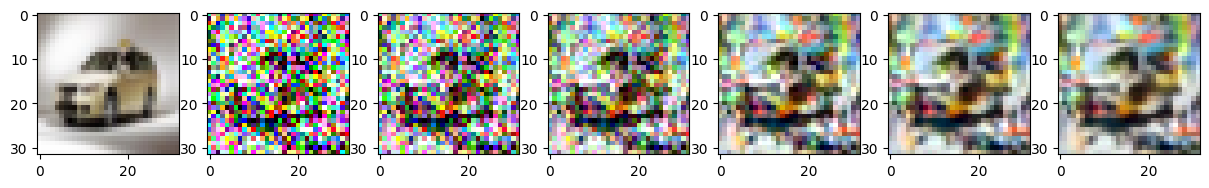

In [38]:
start_idx = 2
repeats = 40

plot_graphs(x, c, n_start, n_sample, start_idx, repeats, device)

(1, 3, 32, 32)
MSELoss()


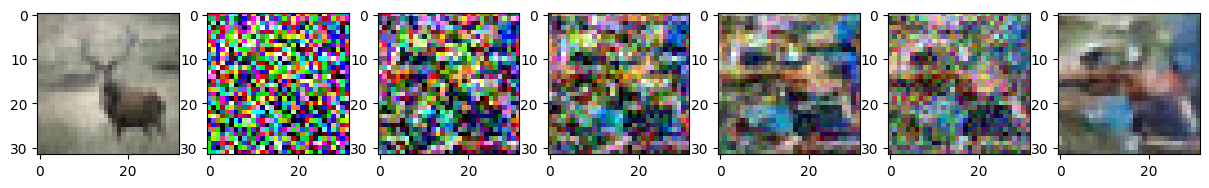

(1, 3, 32, 32)
MSELoss()


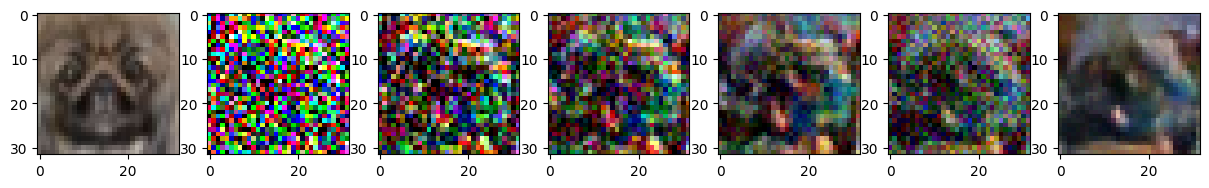

(1, 3, 32, 32)
MSELoss()


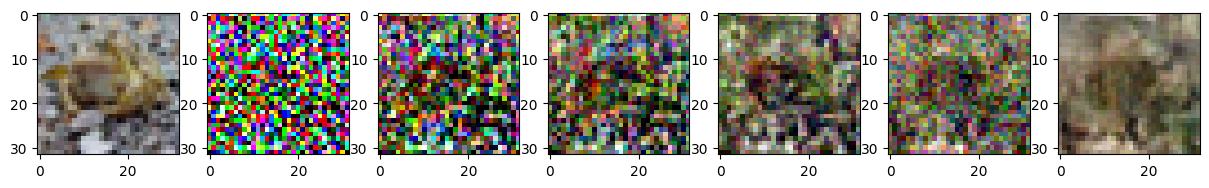

(1, 3, 32, 32)
MSELoss()


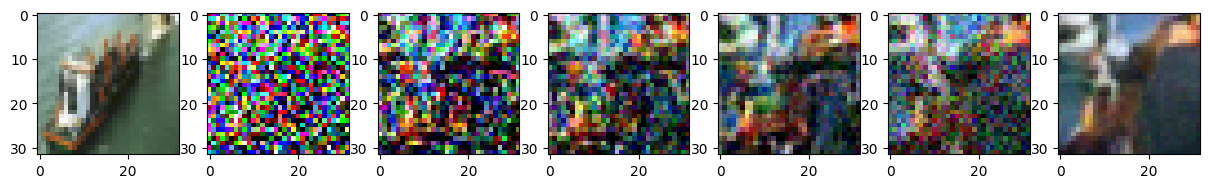

(1, 3, 32, 32)
MSELoss()


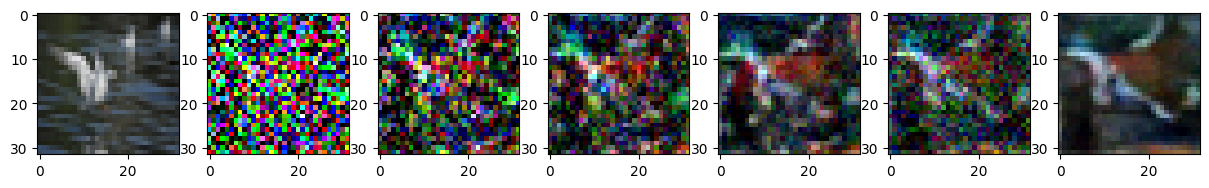

In [26]:
start_idx = 60 # 30% of 200
repeats = 3

plot_graphs(x, c, n_start, n_sample, start_idx, repeats, device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


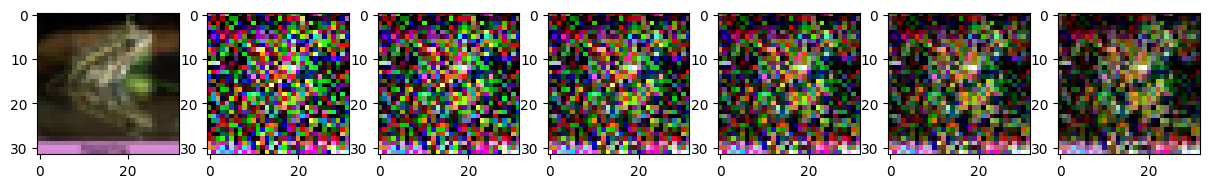

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


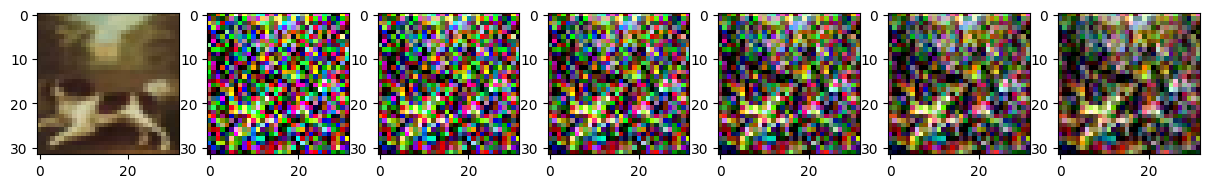

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


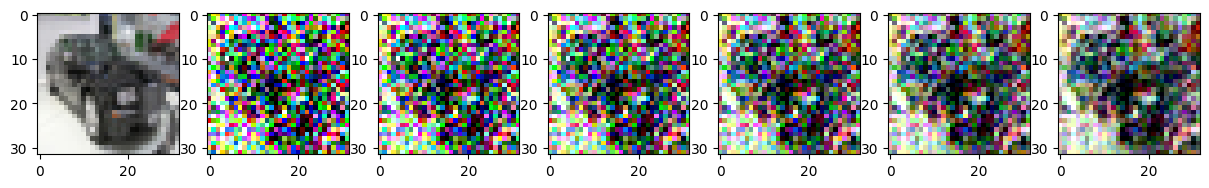

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


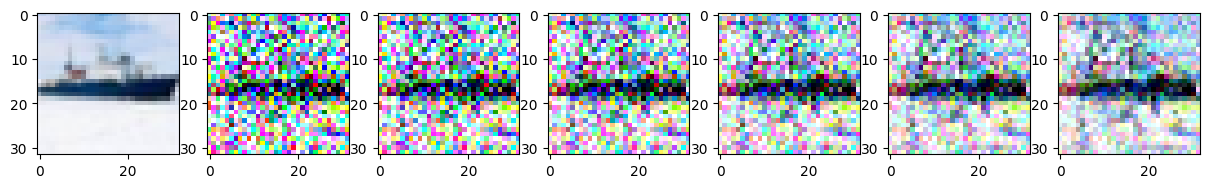

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


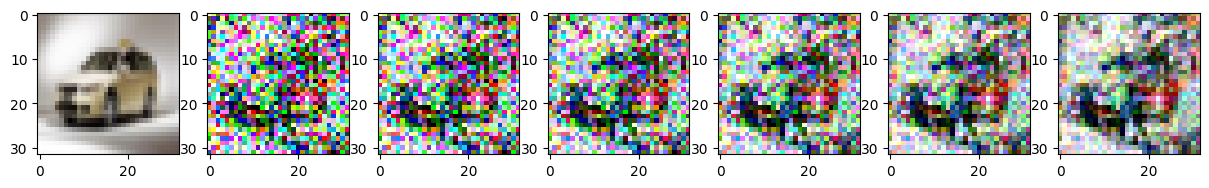

In [39]:
start_idx = 50 # 25% of 200
repeats = 1

plot_graphs(x, c, n_start, n_sample, start_idx, repeats, device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


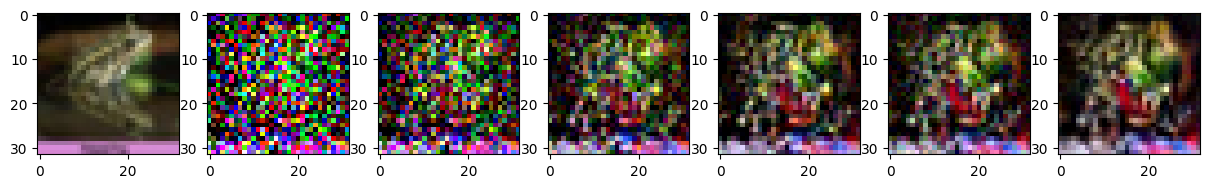

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


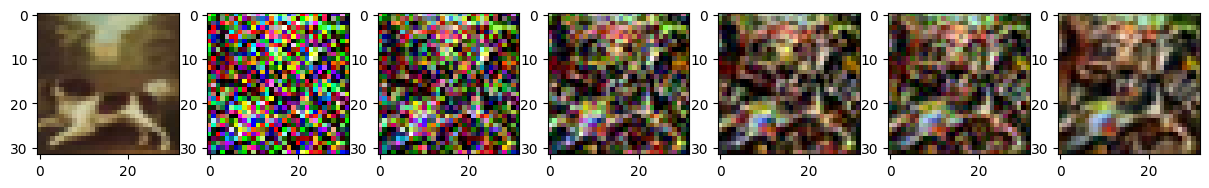

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


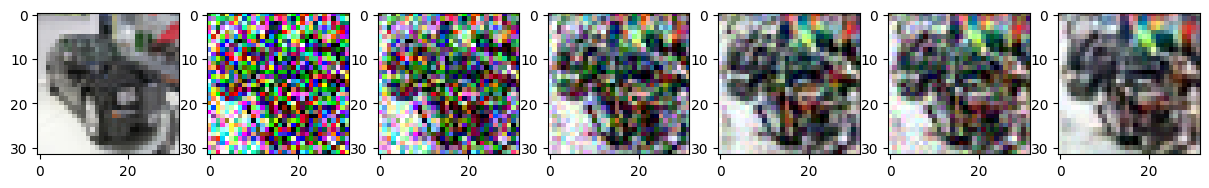

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


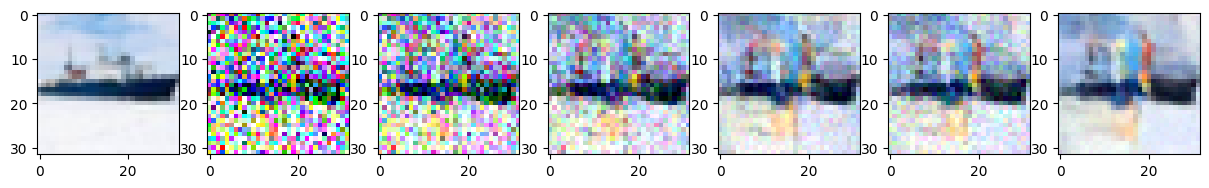

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


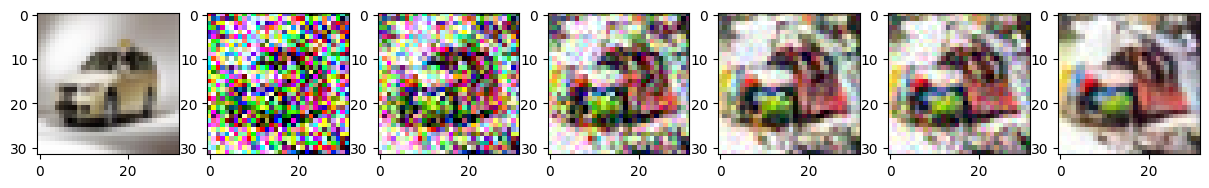

In [40]:
start_idx = 50 # 25% of 200
repeats = 3

plot_graphs(x, c, n_start, n_sample, start_idx, repeats, device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


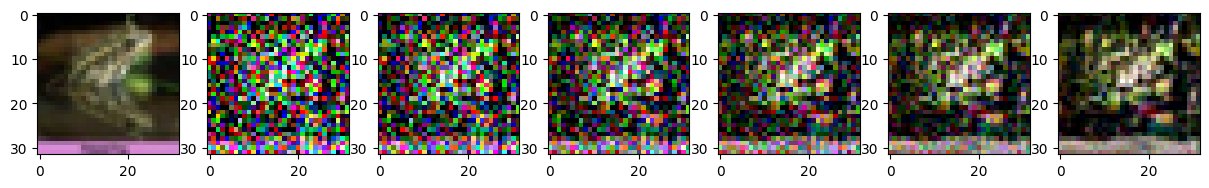

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


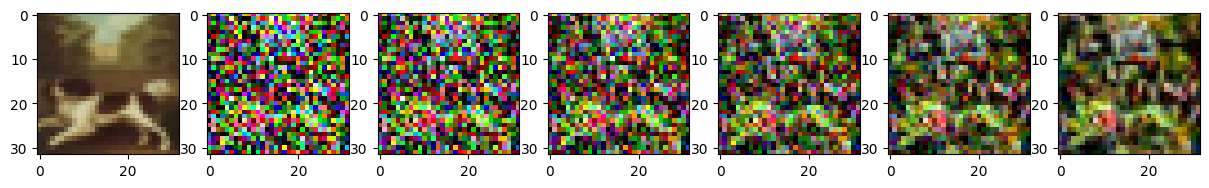

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


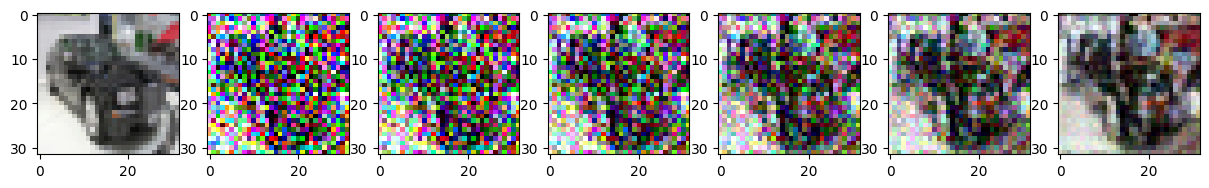

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


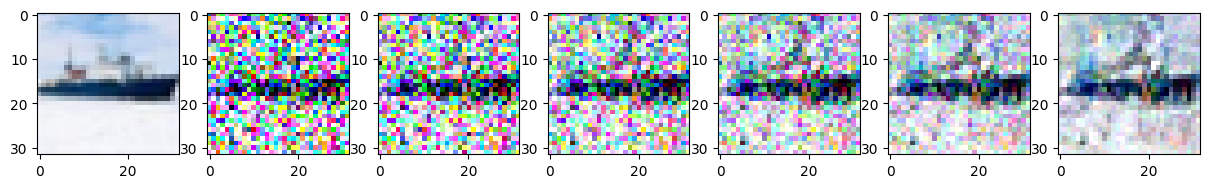

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


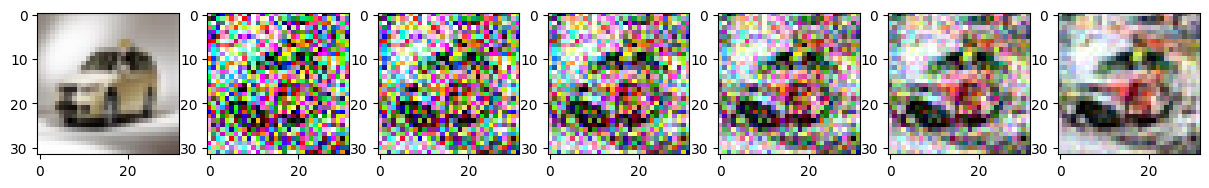

In [41]:
start_idx = 80 # 40% of 200
repeats = 1

plot_graphs(x, c, n_start, n_sample, start_idx, repeats, device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


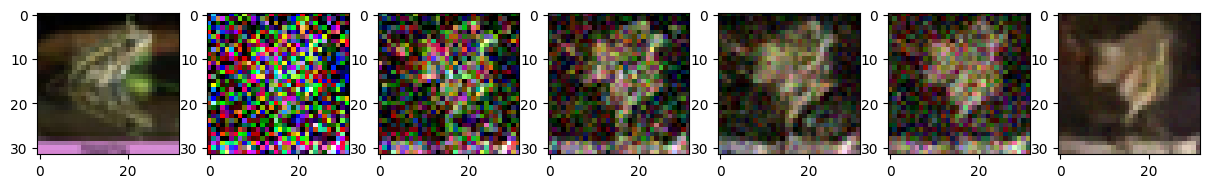

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


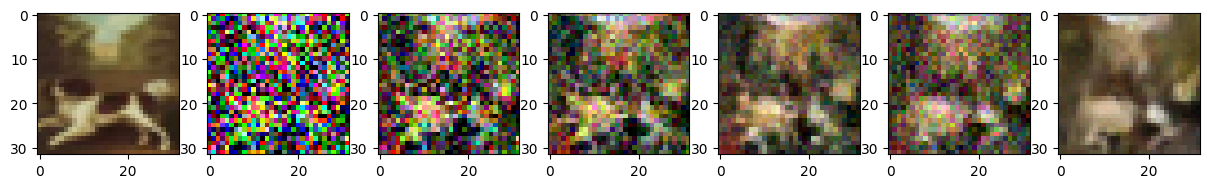

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


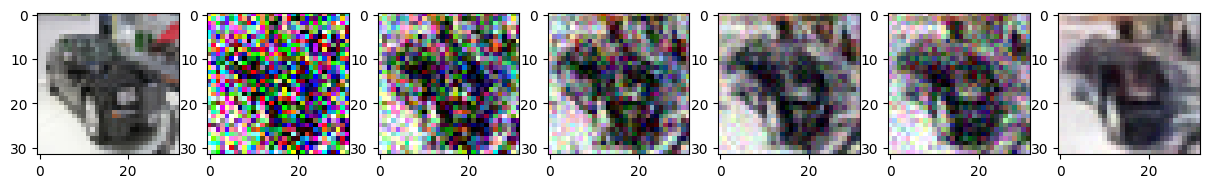

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


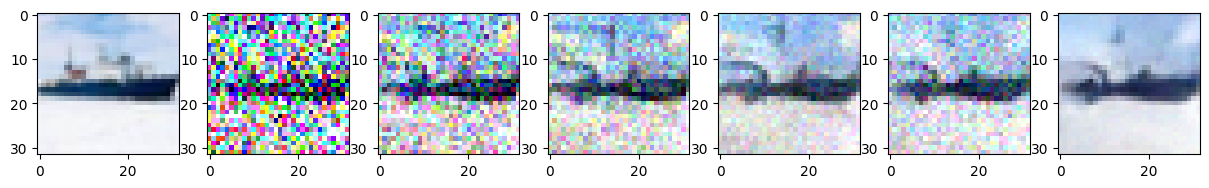

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


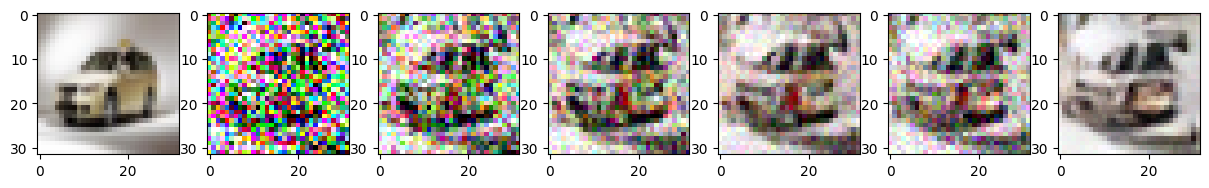

In [42]:
start_idx = 80 # 40% of 200
repeats = 3

plot_graphs(x, c, n_start, n_sample, start_idx, repeats, device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


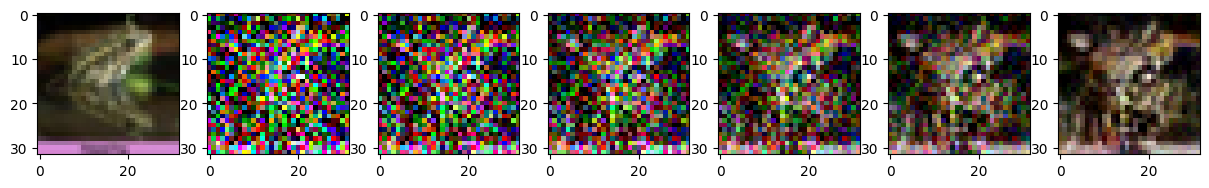

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


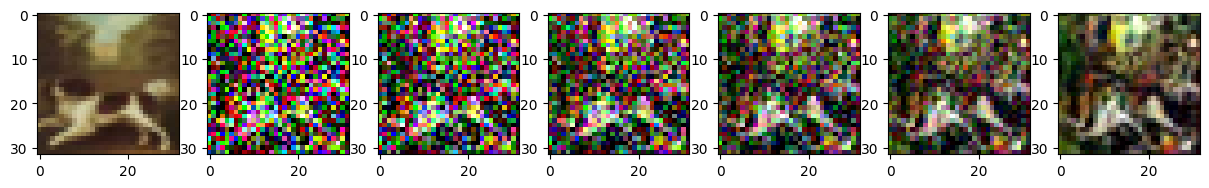

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


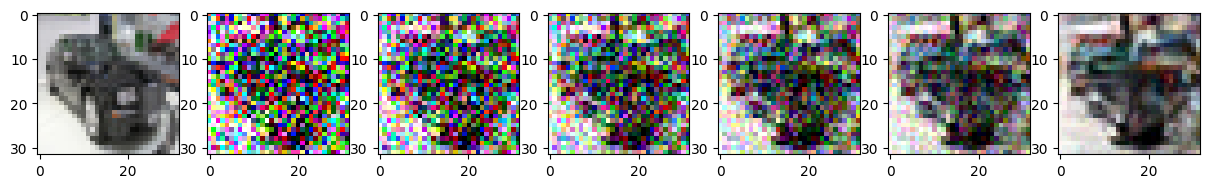

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


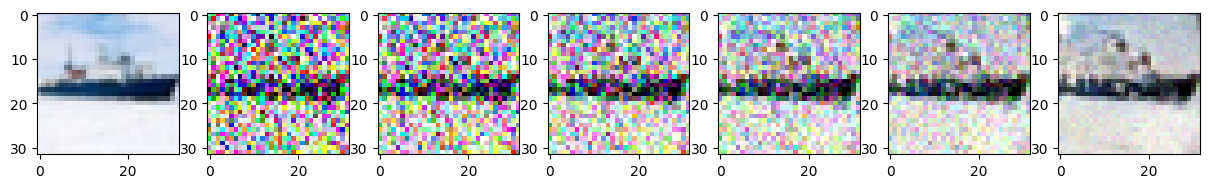

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


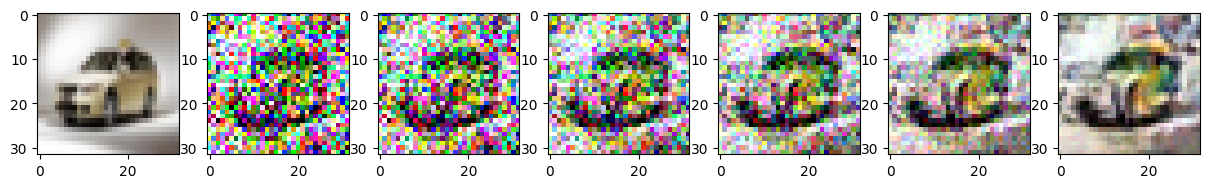

In [44]:
start_idx = 100 # 50% of 200
repeats = 1

plot_graphs(x, c, n_start, n_sample, start_idx, repeats, device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


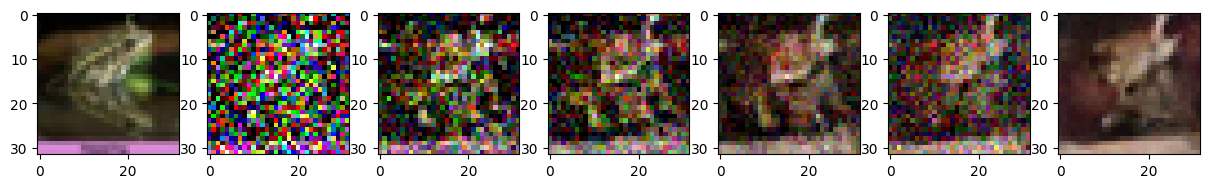

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


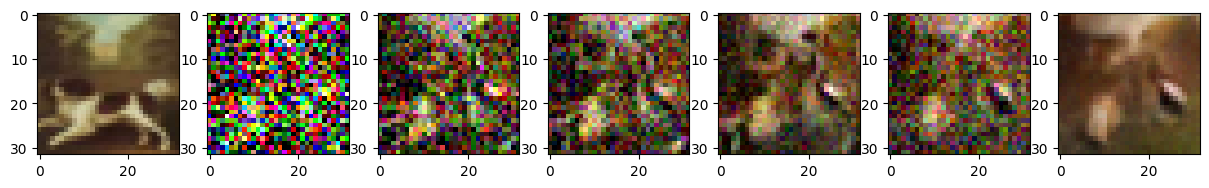

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


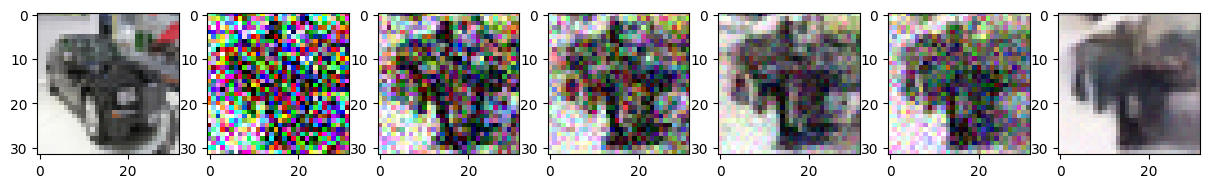

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


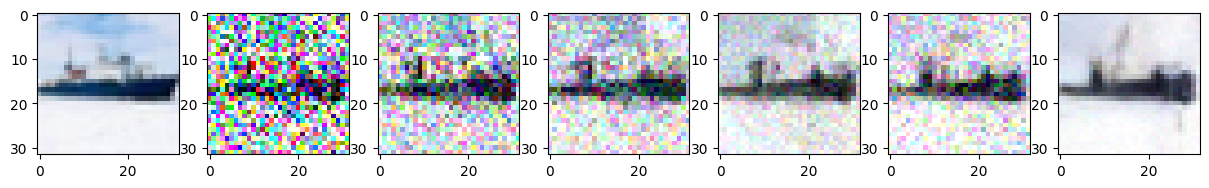

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)
MSELoss()


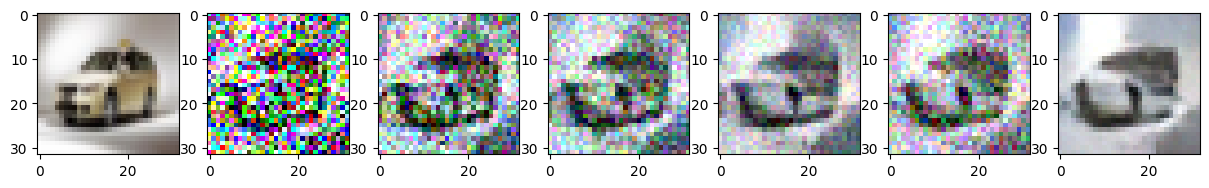

In [45]:
start_idx = 100 # 50% of 200
repeats = 3

plot_graphs(x, c, n_start, n_sample, start_idx, repeats, device)

In [21]:
num_params = sum(p.numel() for p in ddpm.parameters())
print("Number of parameters: ", num_params)

Number of parameters:  7573251
